In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
import tkinter as tk
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import os

In [15]:
# Загрузка данных
(train_images, train_labels), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Преобразование изображений в формат с 1 каналом (черно-белые)
train_images = train_images.reshape((-1, 28, 28, 1)).astype("float32") / 255.0
x_test = x_test.reshape((-1, 28, 28, 1)).astype("float32") / 255.0

# Преобразование меток в one-hot кодировку
train_labels = keras.utils.to_categorical(train_labels, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Файл для сохраненной модели
MODEL_PATH = "mnist_cnn_model_2.h5"

# Функция создания модели
def create_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(16, (5, 5), activation='relu'),
        layers.BatchNormalization(),

        layers.Flatten(),

        layers.Dense(16, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Если модель уже сохранена — загружаем ее
if os.path.exists(MODEL_PATH):
    print("🔹 Загружаем сохраненную модель...")
    final_model = keras.models.load_model(MODEL_PATH)
else:
    print("🔹 Модель не найдена, начинаем обучение...")

    # Кросс-валидация
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_index, val_index in kf.split(train_images):
        X_train, X_val = train_images[train_index], train_images[val_index]
        y_train, y_val = train_labels[train_index], train_labels[val_index]

        model = create_model()
        model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), verbose=0)

        val_predictions = model.predict(X_val)
        val_predicted_labels = np.argmax(val_predictions, axis=1)
        val_true_labels = np.argmax(y_val, axis=1)

        val_accuracy = accuracy_score(val_true_labels, val_predicted_labels)
        accuracies.append(val_accuracy)

    print("✅ Средняя точность по валидации:", np.mean(accuracies))

    # Обучение финальной модели на всех данных
    final_model = create_model()
    final_model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(x_test, y_test))

    # Сохраняем модель
    final_model.save(MODEL_PATH)
    print(f"✅ Модель сохранена в {MODEL_PATH}")

# Оценка на тестовой выборке
test_predictions = final_model.predict(x_test)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(y_test, axis=1)

test_accuracy = accuracy_score(test_true_labels, test_predicted_labels)
print("🎯 Точность на тестовых данных:", test_accuracy)


🔹 Загружаем сохраненную модель...


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
🎯 Точность на тестовых данных: 0.9903


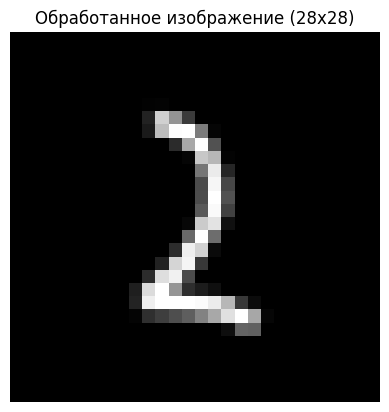

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


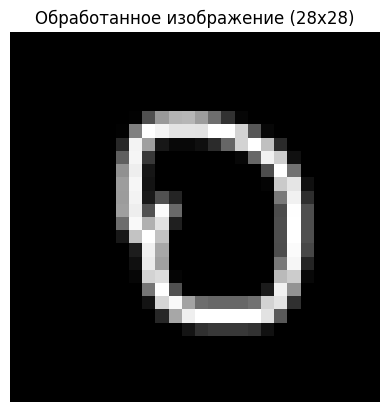

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


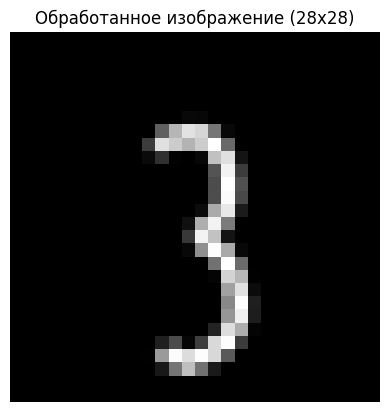

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


In [16]:
# Функция обработки изображения и предсказания цифры
def predict_digit(img):
    img = img.convert("L")  
    img = img.resize((28, 28))  
    img_array = np.array(img)

    # Нормализация (0-1 вместо 0-255)
    img_array = img_array.astype(np.float32) / 255.0

    # Добавляем оси: (28, 28) -> (1, 28, 28, 1)
    img_array = img_array.reshape(1, 28, 28, 1)

    # Визуализация обработанного изображения
    plt.imshow(img_array.squeeze(), cmap="gray")
    plt.title("Обработанное изображение (28x28)")
    plt.axis("off")
    plt.show()

    # Предсказание модели
    probabilities = model.predict(img_array)[0] 
    prediction = np.argmax(probabilities)  # Получаем индекс класса с наибольшей вероятностью

    # Выводим результат в GUI
    label.config(text=f"Prediction: {prediction}", font=("Arial", 20))
    prob_text = "\n".join([f"{i}: {prob*100:.2f}%" for i, prob in enumerate(probabilities)])
    label_probs.config(text=prob_text, font=("Arial", 14), justify="left")

# Функции для рисования
def start_draw(event):
    global last_x, last_y
    last_x, last_y = event.x, event.y

def draw(event):
    global last_x, last_y
    canvas.create_line(last_x, last_y, event.x, event.y, width=16, fill="white", capstyle=tk.ROUND)
    draw_img.line([last_x, last_y, event.x, event.y], fill="white", width=16)
    last_x, last_y = event.x, event.y

def clear_canvas():
    canvas.delete("all")
    draw_img.rectangle((0, 0, 280, 280), fill="black")
    label_probs.config(text="\n".join([f"{i}: 0.0%" for i in range(10)]))
    label.config(text="Prediction: ")

def recognize():
    predict_digit(img)

# Создание GUI
root = tk.Tk()
root.title("Распознавание рукописных цифр")

frame = tk.Frame(root)
frame.pack()

canvas = tk.Canvas(frame, width=300, height=300, bg="black")  # Черный фон
canvas.grid(row=0, column=0, padx=10)

img = Image.new("L", (280, 280), "black")  # Черное изображение для рисования
draw_img = ImageDraw.Draw(img)

canvas.bind("<Button-1>", start_draw)
canvas.bind("<B1-Motion>", draw)

btn_clear = tk.Button(frame, text="Очистить", command=clear_canvas)
btn_clear.grid(row=1, column=0, pady=5)

btn_recognize = tk.Button(frame, text="Распознать", command=recognize)
btn_recognize.grid(row=2, column=0, pady=5)

label_probs = tk.Label(frame, text="\n".join([f"{i}: 0.0%" for i in range(10)]), font=("Arial", 14), justify="left")
label_probs.grid(row=0, column=1, padx=20, sticky="n")

label = tk.Label(frame, text="Prediction: ", font=("Arial", 20))
label.grid(row=1, column=1, sticky="s")

root.mainloop()


In [ ]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 11, 11, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 7, 7, 16)       │        12,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 7, 7, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,984 (414.00 KB)

 Trainable params: 35,274 (137.79 KB)

 Non-trainable params: 160 (640.00 B)

 Optimizer params: 70,550 (275.59 KB)